In [464]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn import preprocessing

In [465]:
df = pd.read_csv("dataframe.csv")
df.head()

,author,author_type,url,location,deal_type,accommodation_type,floor,floors_count,rooms_count,total_meters,...,finish_type,living_meters,kitchen_meters,phone,ceiling_height,district,street,house_number,underground,residential_complex
0,ANT Development,developer,https://www.cian.ru/sale/flat/303519398/,Москва,sale,flat,11,13,5,265.6,...,Чистовая,-1,-1,74951346248,3 м,Дорогомилово,NaN,3к1,Парк Победы,Виктори Парк Резиденсез ЖК
1,ID 18174647,realtor,https://www.cian.ru/sale/flat/301450189/,Москва,sale,flat,26,31,5,246.7,...,-1,"140,9 м²",28 м²,79166462390,"3,1 м",Очаково-Матвеевское,Нежинская,1к1,Давыдково,Кутузовская Ривьера
2,Monumental Group,real_estate_agent,https://www.cian.ru/sale/flat/306835123/,Москва,sale,flat,4,8,5,117.0,...,-1,-1,10 м²,79672086536,"3,2 м",Пресненский,Большая Садовая,3С1,Маяковская,NaN
3,Главстрой,developer,https://www.cian.ru/sale/flat/296921235/,Москва,sale,flat,24,24,5,172.5,...,Без отделки,"104,6 м²","10,5 м²",74951379308,"3,2 м",Филевский парк,Береговой проезд,2,Фили,Береговой-2
4,Рента,real_estate_agent,https://www.cian.ru/sale/flat/307983948/,Москва,sale,flat,3,9,5,234.8,...,-1,140 м²,23 м²,79663231016,-1,Тверской,Краснопролетарская,7,Новослободская,Ласточкино гнездо


In [466]:
df.drop(columns=['author', 'author_type', 'deal_type', 'url', 'accommodation_type', 'phone', 'house_number'], inplace=True)

<Figure size 1000x600 with 0 Axes>

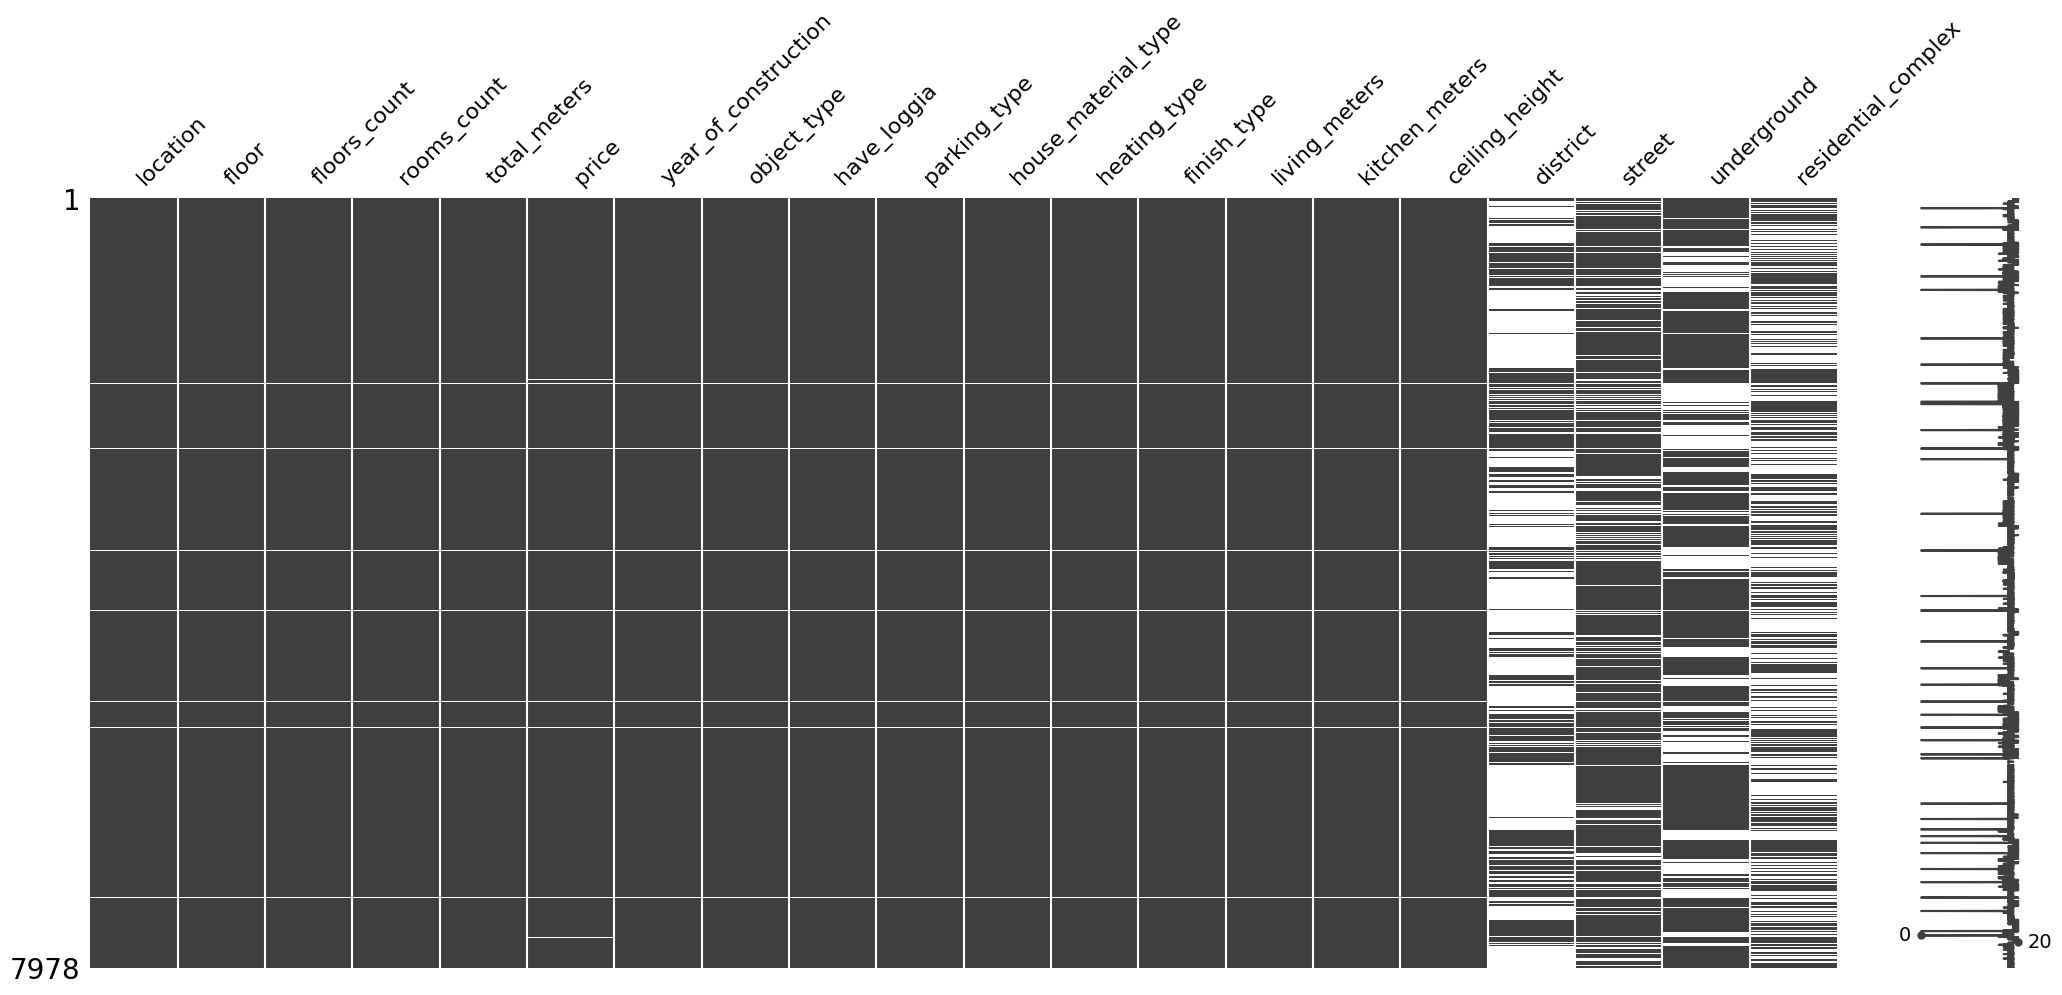

In [467]:
plt.figure(figsize=(10, 6))
msno.matrix(df)
plt.show()

<Figure size 1000x600 with 0 Axes>

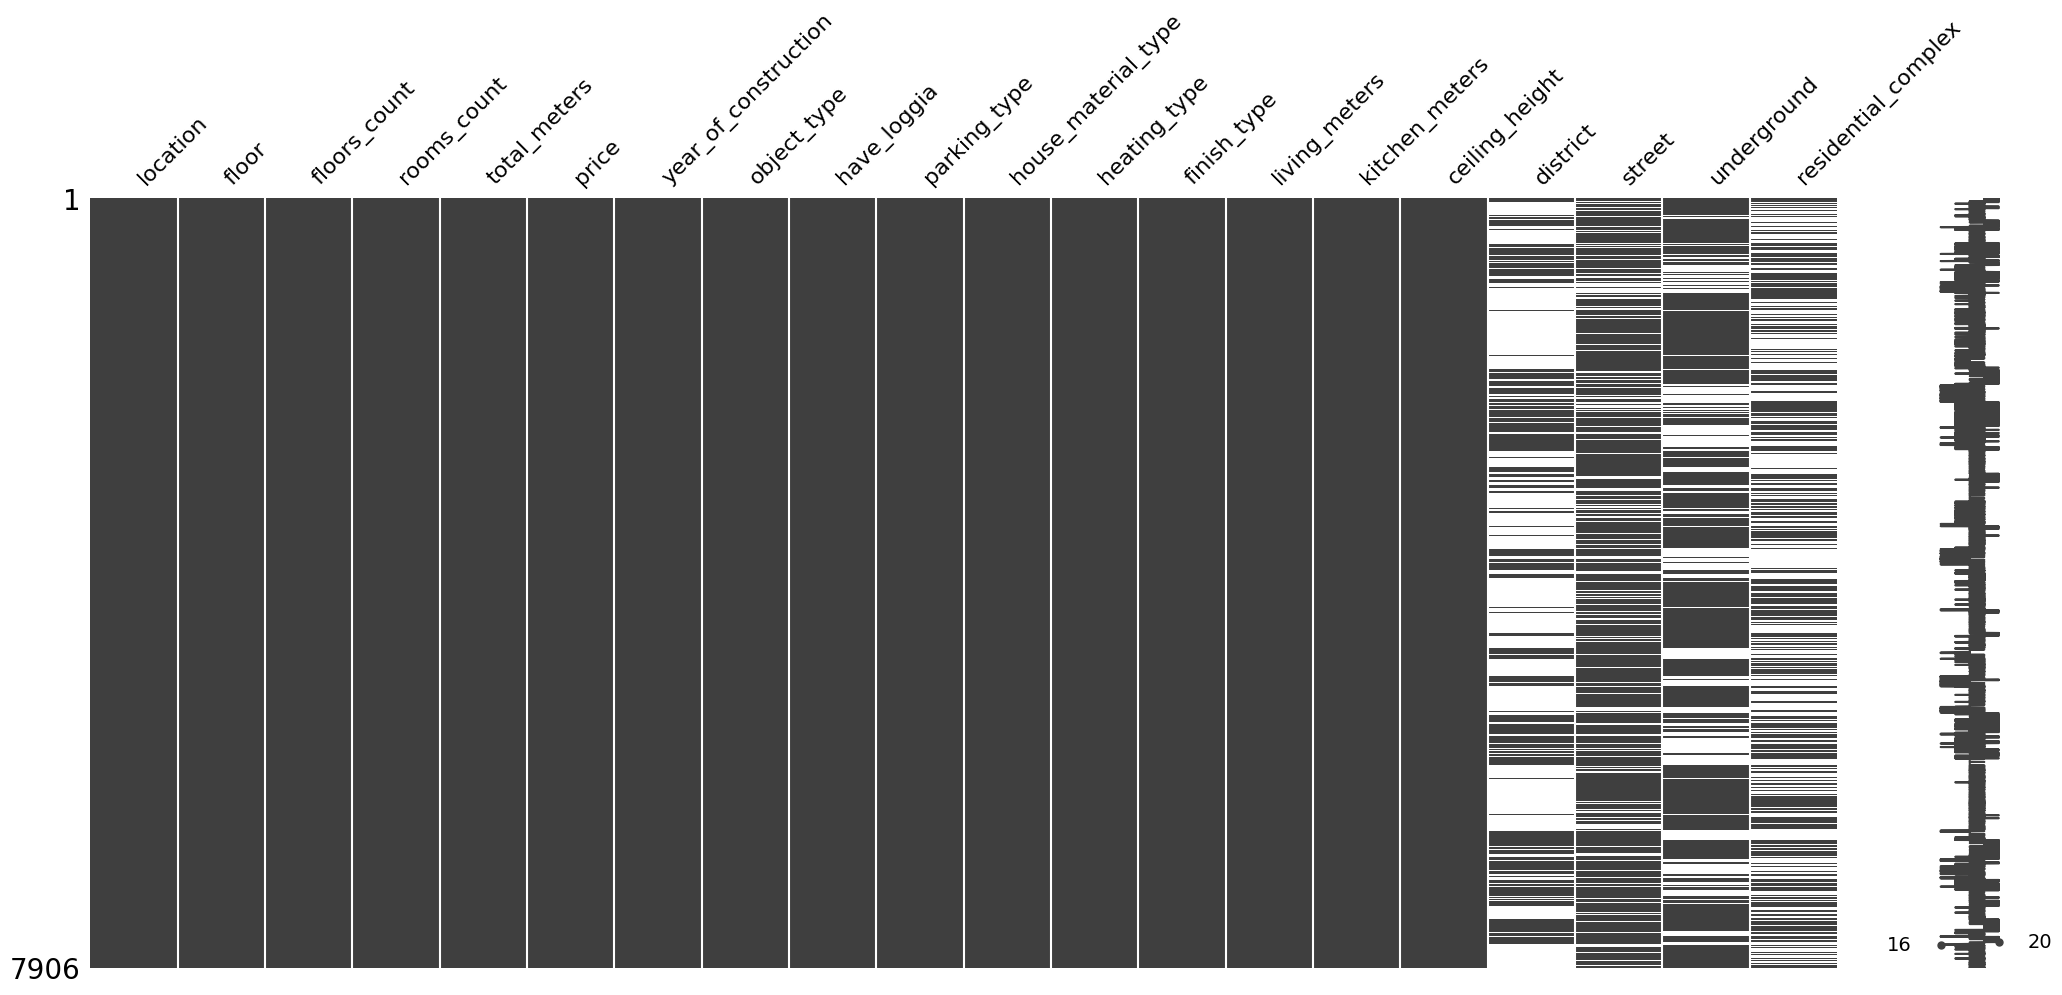

In [468]:
df_cleaned = df.dropna(thresh=3)  
plt.figure(figsize=(10, 6))
msno.matrix(df_cleaned)
plt.show()


In [469]:
df_cleaned.replace(-1, np.nan, inplace=True)

C:\Users\josha\AppData\Local\Temp\ipykernel_19828\2723026629.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.replace(-1, np.nan, inplace=True)


In [470]:
df_cleaned['total_meters'] = pd.to_numeric(df_cleaned['total_meters'], errors='coerce')

print(df_cleaned.isnull().sum())

location                   0
floor                      0
floors_count               0
rooms_count                0
total_meters               1
price                     13
year_of_construction       0
object_type                0
have_loggia                0
parking_type               0
house_material_type        0
heating_type               0
finish_type                0
living_meters              0
kitchen_meters             0
ceiling_height             0
district                4779
street                  1651
underground             2395
residential_complex     3935
dtype: int64


C:\Users\josha\AppData\Local\Temp\ipykernel_19828\2555760361.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['total_meters'] = pd.to_numeric(df_cleaned['total_meters'], errors='coerce')


In [471]:
thresholds = {
    'total_meters': (5, 240) 
} 

In [472]:
for column, (lower, upper) in thresholds.items():
    if column in df_cleaned.columns:
        # Оставляем только строки, удовлетворяющие условиям и имеющие непустые значения
        df_cleaned = df_cleaned[df_cleaned[column].notna() & (df_cleaned[column] >= lower) & (df_cleaned[column] <= upper)]
    else:
        print(f"Столбец '{column}' не найден.")

print("\nРазмеры DataFrame после удаления выбросов:")
print(df_cleaned.shape)


Размеры DataFrame после удаления выбросов:
(7876, 20)


In [473]:
df_cleaned['price'] = pd.to_numeric(df_cleaned['price'], errors='coerce')

In [474]:
if df_cleaned['total_meters'].isnull().any() or df_cleaned['price'].isnull().any():
    print("Внимание: В столбцах 'price' или 'total_meters' есть недопустимые значения. Проверьте данные.")


Внимание: В столбцах 'price' или 'total_meters' есть недопустимые значения. Проверьте данные.


In [475]:
def number_encode_features(init_df):
    result = init_df.copy()  # Копируем исходную таблицу
    encoders = {}  # Словарь для хранения кодировщиков
    for column in result.columns:
        if result[column].dtype == 'object':  # Если тип столбца - строка
            encoders[column] = preprocessing.LabelEncoder()  # Создаем кодировщик
            result[column] = encoders[column].fit_transform(result[column])  # Кодируем столбец
    return result, encoders

In [476]:
def remove_outliers(df, columns):
    """Удаляет выбросы на основе 1.5 IQR для указанных столбцов."""
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

In [477]:
df_cleaned = remove_outliers(df_cleaned, ['total_meters', 'price'])

In [478]:
encoded_data, encoders = number_encode_features(df_cleaned)

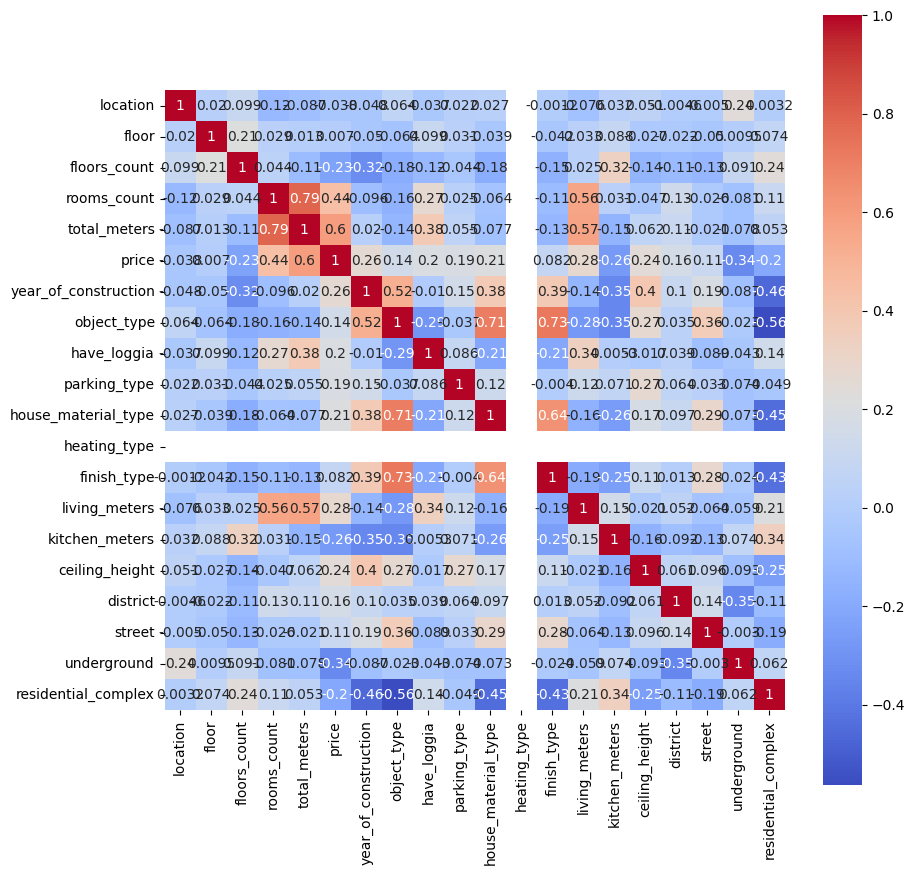

In [479]:
plt.subplots(figsize=(10, 10))
sns.heatmap(encoded_data.corr(), square=True, annot=True, cmap='coolwarm')
plt.show()

In [480]:
df_cleaned['price_per_sqm'] = df_cleaned['price'] / df_cleaned['total_meters']

In [481]:
df_cleaned = df_cleaned[df_cleaned['total_meters'] > 0]

In [482]:
average_price_per_sqm = df_cleaned['price_per_sqm'].mean()

In [483]:
print(f"\nСредняя цена за квадратный метр: {average_price_per_sqm:.2f} единиц валюты")


Средняя цена за квадратный метр: 172064.66 единиц валюты


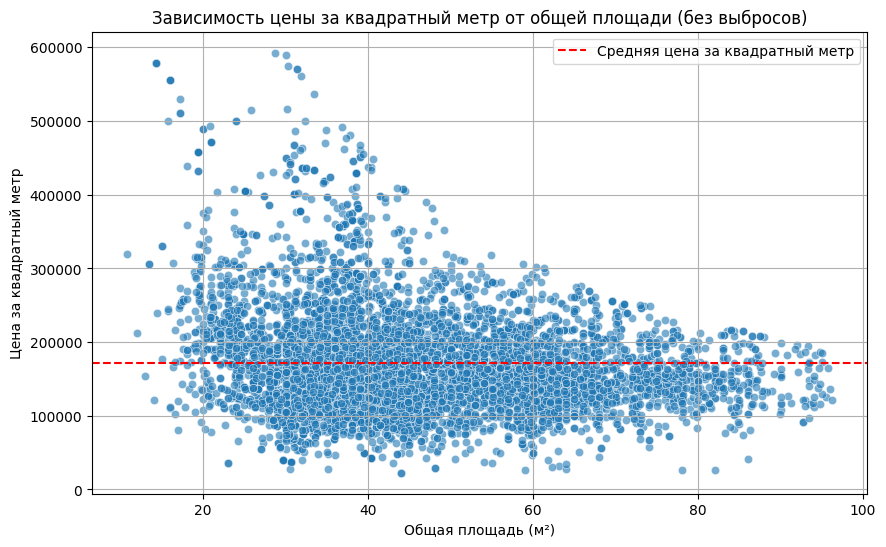

In [484]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_cleaned, x='total_meters', y='price_per_sqm', alpha=0.6)
plt.title('Зависимость цены за квадратный метр от общей площади (без выбросов)')
plt.xlabel('Общая площадь (м²)')
plt.ylabel('Цена за квадратный метр')
plt.axhline(y=average_price_per_sqm, color='r', linestyle='--', label='Средняя цена за квадратный метр')
plt.legend()
plt.grid()
plt.show()